In [1]:
# Import Libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [2]:
# Define the file path
file_path = 'Data/Processed Data/'

# Load the dataframe
df = pd.read_csv(file_path + 'preprocessed_data.csv')

In [3]:
# Check for missing values in the entire dataframe
missing_values = df.isnull().sum().sum()

# Alternatively, you can check for missing values in each column
missing_values_per_column = df.isnull().sum()

# Print the results
print("Total missing values:", missing_values)
print("Missing values per column:")
print(missing_values_per_column)


Total missing values: 0
Missing values per column:
Date/Time      0
Lat            0
Lon            0
Base           0
Date           0
Time           0
Month_Name     0
Month          0
YearMonth      0
Hour           0
Weekday        0
Day_Type       0
IsHoliday      0
Time_of_day    0
Cluster        0
Location       0
dtype: int64


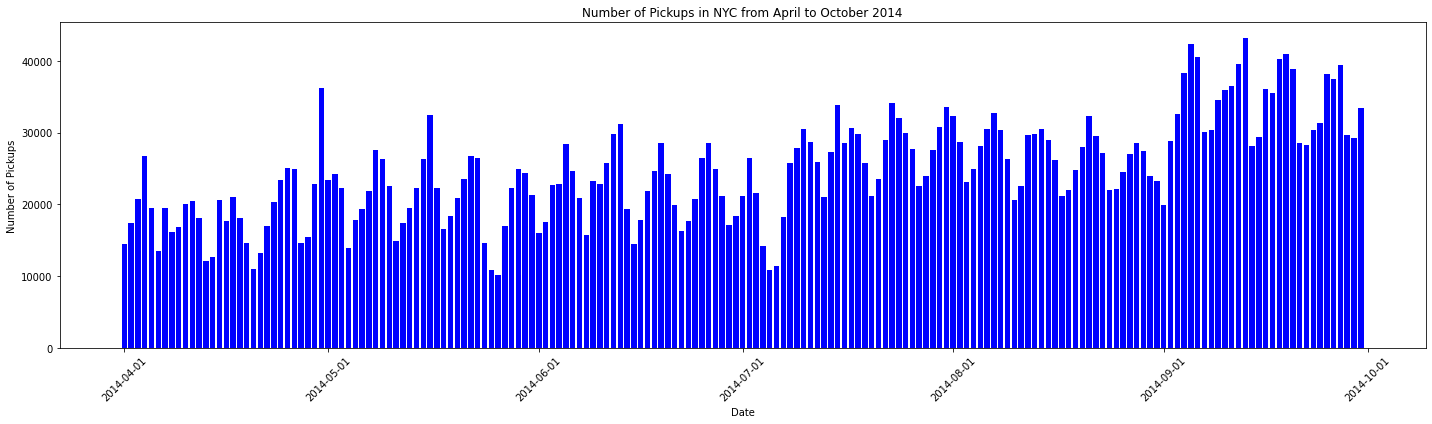

In [4]:
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Count the number of entries for each date
date_counts = df['Date'].value_counts().sort_index()

# Create a bar chart
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(date_counts.index, date_counts.values, color='blue')

# Format the x-axis to show the first day of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Number of Pickups')
plt.title('Number of Pickups in NYC from April to October 2014')
plt.tight_layout()
plt.show()

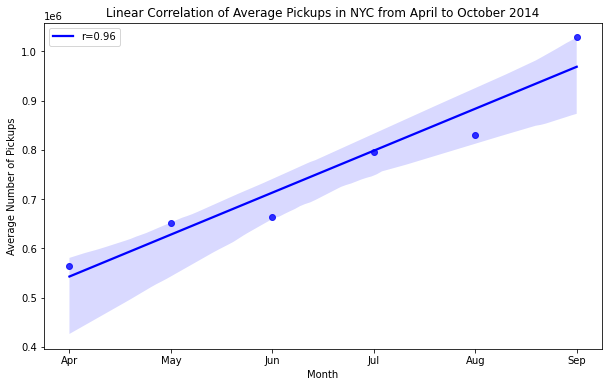

In [5]:
# Calculate average number of entries per month
avg_entries = df.groupby('YearMonth').size().reset_index(name='AvgEntries')

# Create a new column for month number (1 for January, 2 for February, etc.)
avg_entries['Month'] = range(1, len(avg_entries) + 1)

# Create a linear regression model
model = LinearRegression()

# Fit the model with data
X = avg_entries['Month'].values.reshape(-1,1)
y = avg_entries['AvgEntries']
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate the correlation coefficient
corr, _ = pearsonr(X.flatten(), y)

# Create a linear regression plot
plt.figure(figsize=(10,6))
sns.regplot(x='Month', y='AvgEntries', data=avg_entries, color='blue', line_kws={'label':"r={:.2f}".format(corr)})

# Set the x-axis to display month names
plt.xticks(ticks=avg_entries['Month'], labels=df['Month_Name'].unique())

plt.xlabel('Month')
plt.ylabel('Average Number of Pickups')
plt.title('Linear Correlation of Average Pickups in NYC from April to October 2014')
plt.legend()
plt.show()



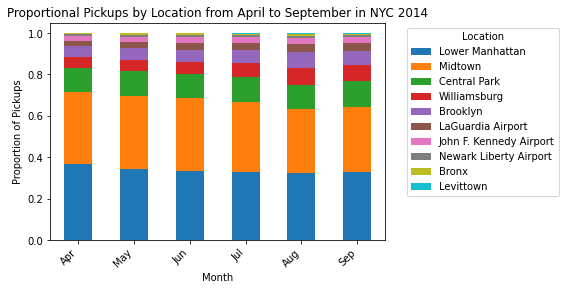

In [6]:
# Create a mapping from cluster number to location
cluster_to_location = df.set_index('Cluster')['Location'].to_dict()

# Replace cluster numbers with locations
df['Cluster'] = df['Cluster'].map(cluster_to_location)

# Group by Month and Cluster (now containing locations), then unstack
grouped = df.groupby(['Month', 'Cluster']).size().unstack()

# Calculate proportions
grouped_prop = grouped.divide(grouped.sum(axis=1), axis=0)

# Sort the DataFrame by the sum of each column (i.e., the total number of entries for each cluster)
grouped_prop = grouped_prop.reindex(grouped_prop.sum().sort_values(ascending=False).index, axis=1)

# Create the plot
ax = grouped_prop.plot(kind='bar', stacked=True)

# Set the x-axis labels to 'Month_Name'
ax.set_xticklabels(df['Month_Name'].unique(), rotation=45, ha='right')

plt.xlabel('Month')
plt.ylabel('Proportion of Pickups')
plt.title('Proportional Pickups by Location from April to September in NYC 2014')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


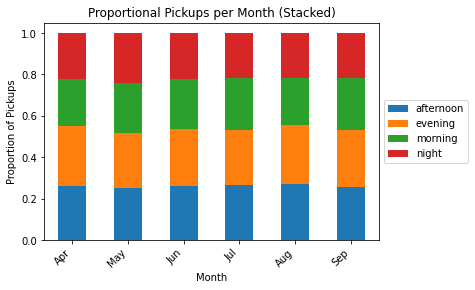

In [7]:
# Group the DataFrame by 'Month_Name' and 'Time_of_day' and calculate the count
grouped_df = df.groupby(['Month_Name', 'Time_of_day']).size().unstack()

# Calculate the sum of each row to get the total count per month
row_sums = grouped_df.sum(axis=1)

# Divide each value in the DataFrame by the corresponding row sum to get proportional values
proportional_df = grouped_df.div(row_sums, axis=0)

# Create a stacked proportional bar plot
ax = proportional_df.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Proportion of Pickups')
plt.title('Proportional Pickups per Month (Stacked)')

# Move the legend outside of the chart
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set the x-axis labels to 'Month_Name'
ax.set_xticklabels(df['Month_Name'].unique(), rotation=45, ha='right')

# Display the plot
plt.show()

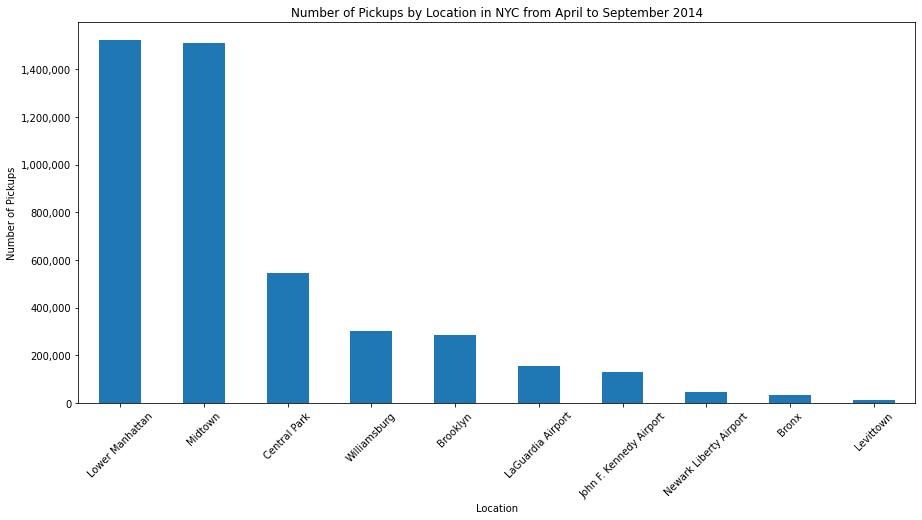

In [9]:
# Group by Location and calculate the size of each group
grouped = df.groupby('Location').size()

# Sort the Series by the number of Pickups
grouped = grouped.sort_values(ascending=False)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 7))  # Adjust the size of the plot
grouped.plot(kind='bar', ax=ax)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format the y-axis labels

plt.xlabel('Location')
plt.ylabel('Number of Pickups')
plt.title('Number of Pickups by Location in NYC from April to September 2014')
plt.xticks(rotation=45)

plt.show()


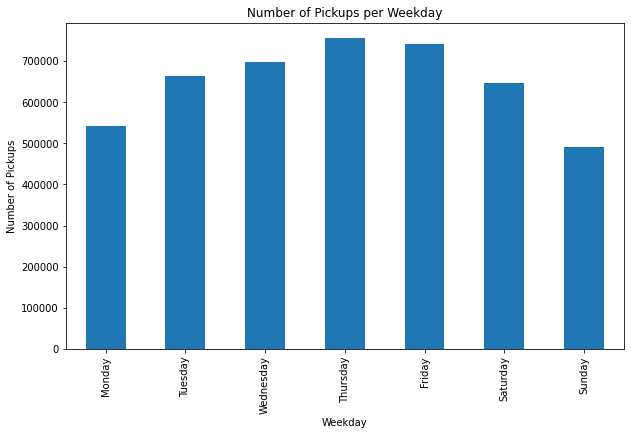

In [10]:
# Create an ordered category for weekdays
df['Weekday'] = pd.Categorical(df['Weekday'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

# Count the number of entries for each weekday
weekday_counts = df['Weekday'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10,6))
weekday_counts.plot(kind='bar')
plt.title('Number of Pickups per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Pickups')
plt.show()


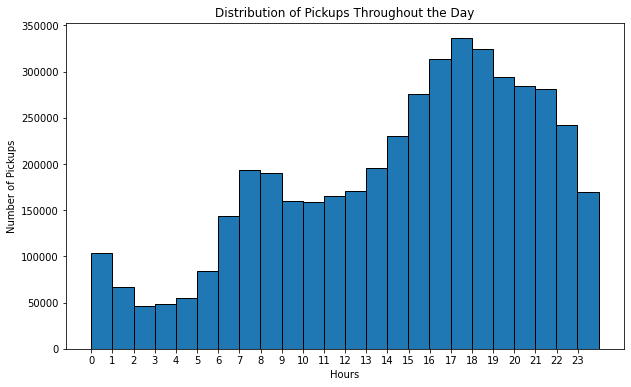

In [11]:
# Converting the 'Time' column into a datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# Create a new column 'Time_in_seconds'
df['Time_in_seconds'] = df['Time'].dt.hour * 3600 + df['Time'].dt.minute * 60 + df['Time'].dt.second

# Create a histogram
plt.figure(figsize=(10,6))
plt.hist(df['Time_in_seconds'], bins=24, edgecolor='black')
plt.title('Distribution of Pickups Throughout the Day')
plt.xlabel('Hours')
plt.ylabel('Number of Pickups')
plt.xticks(ticks=range(0, 24*3600, 3600), labels=range(24))  # Set x-ticks to be hours
plt.show()

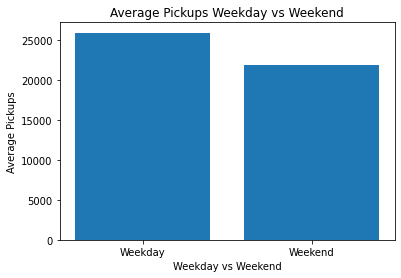

In [12]:
# Calculate the average number of entries on weekdays and weekends
weekday_avg = df['Day_Type'].value_counts()['Weekday'] / df[df['Day_Type'] == 'Weekday']['Date'].nunique()
weekend_avg = df['Day_Type'].value_counts()['Weekend'] / df[df['Day_Type'] == 'Weekend']['Date'].nunique()

# Create a bar chart
plt.bar(['Weekday', 'Weekend'], [weekday_avg, weekend_avg])

# Add labels and title
plt.xlabel('Weekday vs Weekend')
plt.ylabel('Average Pickups')
plt.title('Average Pickups Weekday vs Weekend')

# Display the chart
plt.show()

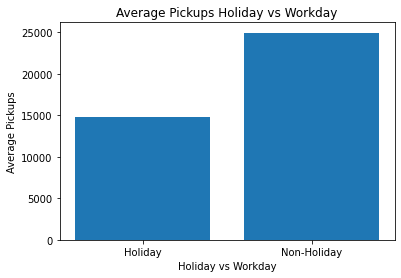

In [13]:
# Calculate the average number of entries on holidays and non-holidays
holiday_avg = df['IsHoliday'].value_counts()[True] / df[df['IsHoliday'] == True]['Date'].nunique()
non_holiday_avg = df['IsHoliday'].value_counts()[False] / df[df['IsHoliday'] == False]['Date'].nunique()

# Create a bar chart
plt.bar(['Holiday', 'Non-Holiday'], [holiday_avg, non_holiday_avg])

# Add labels and title
plt.xlabel('Holiday vs Workday')
plt.ylabel('Average Pickups')
plt.title('Average Pickups Holiday vs Workday')

# Display the chart
plt.show()

EDA for Model Training

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [16]:
# Define the file path
file_path_cluster = 'Data/Model Data/'

# Load the dataframe
cluster_0_data = pd.read_csv(file_path_cluster + 'cluster_0_data.csv')

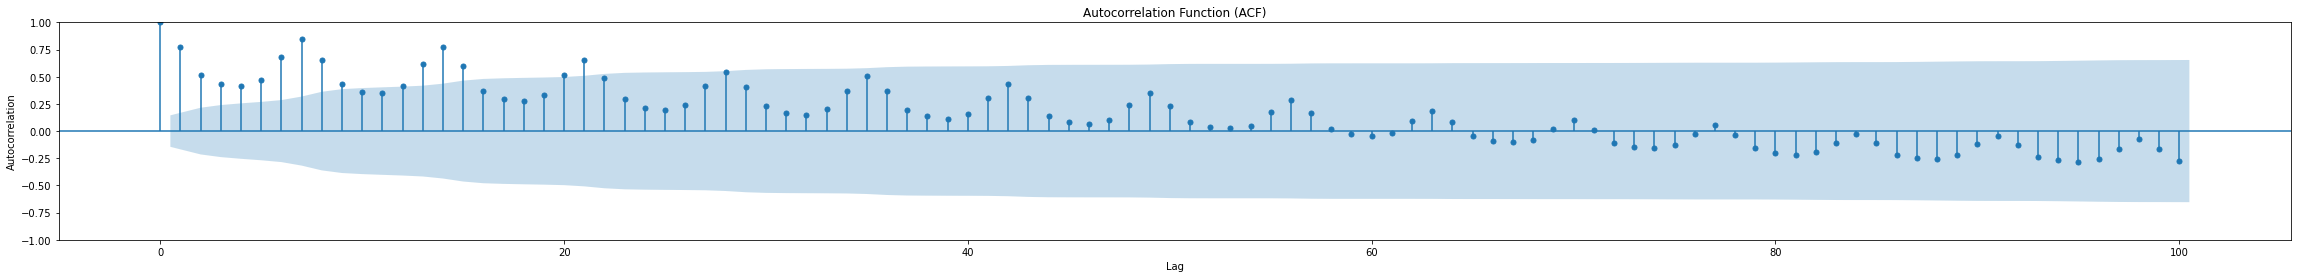

In [18]:
# Use the Pickups Per Hour as column to be analyzed
data = cluster_0_data['Pickups Per Hour']

# Create ACF plot
fig, ax = plt.subplots(figsize=(40, 4))
plot_acf(data, ax=ax, lags=100)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.show()

c:\Users\schwe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


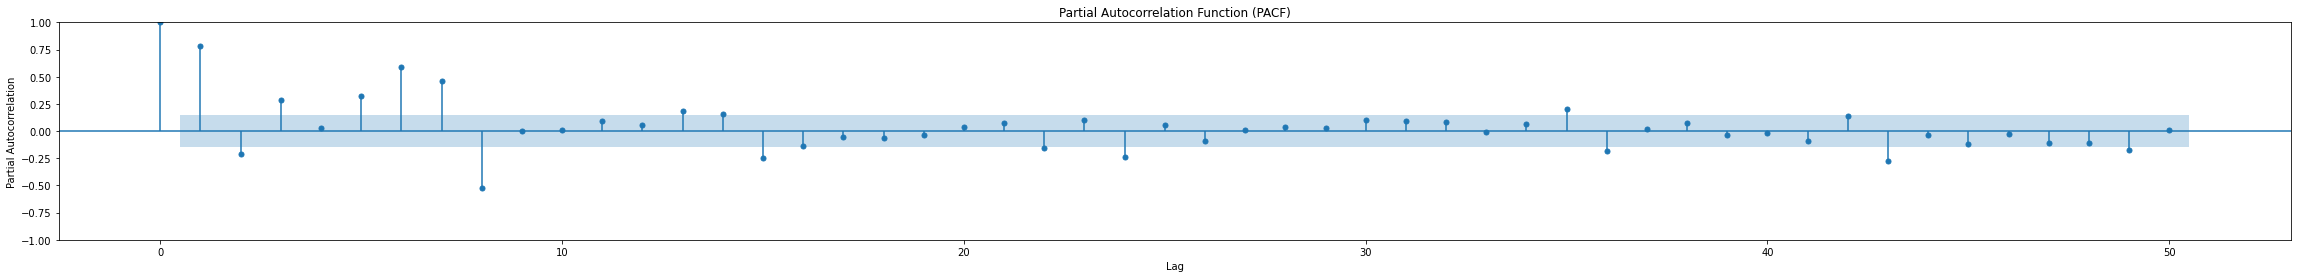

In [19]:
# Create PACF plot
fig, ax = plt.subplots(figsize=(40, 4))
plot_pacf(data, ax=ax, lags=50)
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')
plt.show()